# Statistical analysis + error analysis eval runs

## Setup

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
pd.set_option("display.width", 100)
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from statsmodels.graphics.api import interaction_plot, abline_plot
from statsmodels.stats.anova import anova_lm
import seaborn as sns

from scipy import stats
import math

from collections import Counter

pd.set_option('precision', 5)
pd.set_option('display.float_format', lambda x: '%.5f' % x)




### Load files

In [20]:
experiments = pd.read_csv('../evaluation/resources/2020/all_experiments_eval.csv')
experiments.source = experiments.source.apply(lambda row: row.replace('_TREC-Fair-Ranking-eval-sample-full-annotations-DocLevel-mixed_group-qrels_EEL',''))
experiments

,difference,disparity,relevance,difference_ind,disparity_ind,relevance_ind,qid,source
0,0.23910,1.42244,1.24913,0.14971,0.03529,0.01117,95,ac_controller_default_lm
1,0.76381,1.77053,1.38972,0.44681,0.17976,0.08696,612,ac_controller_default_lm
2,2.69675,1.76200,0.32276,0.77073,0.11388,0.06241,657,ac_controller_default_lm
3,0.17600,1.81185,1.29111,0.67444,0.25027,0.17895,771,ac_controller_default_lm
4,0.37616,1.73422,1.56520,0.48771,0.31650,0.20156,822,ac_controller_default_lm
...,...,...,...,...,...,...,...,...
1795,0.05434,1.86368,1.61798,0.88898,1.06764,0.18810,119231,relevance_ranker_eval_TEXT_eval
1796,0.01025,2.05438,1.91161,0.59300,1.08332,0.63665,123512,relevance_ranker_eval_TEXT_eval
1797,0.28198,1.23715,0.85092,0.98350,1.08307,0.13868,126740,relevance_ranker_eval_TEXT_eval
1798,0.03991,1.18031,1.05937,0.54097,1.06769,0.55050,128050,relevance_ranker_eval_TEXT_eval


### effect size methods

In [21]:
def omega_squared(ms_effect, ms_error, df_effect, ss_total):
    return (df_effect * (ms_effect - ms_error)) / (ss_total - ms_error)

In [22]:
def omega_squared_partial(ms_effect, ms_error, df_effect, total_observations):
    return (df_effect * (ms_effect - ms_error)) / ((total_observations - df_effect) * ms_error)

In [23]:
def eta_squared(ss_effect, ss_total, roundd=True):
    if roundd:
        return round(ss_effect/ss_total,5)
    else:
        return ss_effect/ss_total

In [24]:
def eta_squared_partial(ss_effect, ss_error, roundd=True):
    if roundd:
        return round(ss_effect/(ss_effect + ss_error),5)
    else:
        return ss_effect/(ss_effect + ss_error)

In [25]:
def cohens_d(m1, m2, ms_error):
    return abs(m1 - m2) / math.sqrt(ms_error)

In [68]:
def ci(num_observations, ms_error):
    t = stats.t.ppf(1-0.025, num_observations)
    return t*math.sqrt(ms_error/num_observations)

## Overall performance

In [27]:
experiments.groupby('source').mean()

,difference,disparity,relevance,difference_ind,disparity_ind,relevance_ind,qid
source,,,,,,,
ac_controller_default_lm,0.41559,1.84050,1.33291,0.51367,0.23806,0.16411,43107.52500
ac_controller_default_meta_9_eval,0.40315,1.84397,1.34087,0.49501,0.19412,0.15147,43107.52500
ac_controller_default_meta_9_eval_old_config,0.42889,1.90082,1.35642,0.57185,0.26984,0.15091,43107.52500
ac_controller_default_text_9_eval,0.41089,1.85321,1.34161,0.49868,0.19300,0.14907,43107.52500
ac_controller_default_text_9_eval_old_config,0.44616,1.91961,1.35718,0.58846,0.27997,0.14766,43107.52500
lambdamart_mrfr_default_default_random_state=0,0.90086,2.25789,1.29897,1.46104,1.25760,0.20019,43107.52500
mrfr_default_lm_eval,0.43274,1.85077,1.32947,0.54498,0.28124,0.17004,43107.52500
relevance_ranker_eval_META_eval,0.84711,2.31496,1.35438,1.44820,1.25602,0.20582,43107.52500
relevance_ranker_eval_TEXT_eval,0.91308,2.35879,1.34331,1.47438,1.25879,0.19412,43107.52500


## Is there a significant improvement in the performance of LambdaMart + RFR vs LambdaMart without RFR?

### Select data

In [112]:
data = experiments[(experiments.source == 'lambdamart_mrfr_default_default_random_state=0') | (experiments.source == 'mrfr_default_lm_eval')]
data = data.reset_index(drop=True)
data

,difference,disparity,relevance,difference_ind,disparity_ind,relevance_ind,qid,source
0,3.43921,2.37181,0.12376,1.47008,1.33333,0.00000,95,lambdamart_mrfr_default_default_random_state=0
1,0.23849,3.17613,2.35518,1.76139,1.33327,0.00643,612,lambdamart_mrfr_default_default_random_state=0
2,4.47004,3.04736,0.07879,2.10123,1.33333,0.00688,657,lambdamart_mrfr_default_default_random_state=0
3,1.74291,3.45954,1.33150,1.76575,1.31771,0.16702,771,lambdamart_mrfr_default_default_random_state=0
4,0.01132,1.63152,1.69627,0.54744,1.06771,0.54729,822,lambdamart_mrfr_default_default_random_state=0
...,...,...,...,...,...,...,...,...
395,0.06794,2.07851,1.71860,0.07524,0.15761,0.13995,119231,mrfr_default_lm_eval
396,0.10978,2.17396,1.92162,0.57496,0.35774,0.28288,123512,mrfr_default_lm_eval
397,0.27117,1.42900,0.95225,0.16322,0.19395,0.10425,126740,mrfr_default_lm_eval
398,0.48640,1.10121,0.79658,0.40619,0.19921,0.18365,128050,mrfr_default_lm_eval


### t-test eel

In [113]:
from scipy import stats
a = data.query('source == "lambdamart_mrfr_default_default_random_state=0"')['difference'].reset_index(drop=True)
b = data.query('source == "mrfr_default_lm_eval"')['difference'].reset_index(drop=True)

In [114]:
stats.ttest_rel(a, b)

Ttest_relResult(statistic=8.407746186402683, pvalue=7.973218663966157e-15)

The difference in scores is significant, p = 0.00000 < 0.05.

In [115]:
def effect_size_t_test(a,b):
    differences = a - b
    sample_mean = differences.sum()/len(differences)
    sample_variance = (differences - sample_mean).apply(lambda x: x*x).sum()/len(differences)
    return abs(sample_mean) / math.sqrt(sample_variance)

In [116]:
effect_size_t_test(a,b)

0.5960093248021374

The effect size is moderate.

In [117]:
differences = a - b.reset_index(drop=True)
sample_mean = differences.sum()/len(differences)
sample_variance = (differences - sample_mean).apply(lambda x: x*x).sum()/len(differences)

In [118]:
c = ci(len(differences), sample_variance)
cl, ch = (sample_mean - c, sample_mean + c)
round(cl,5), round(ch,5)

(0.35861, 0.57764)

In [119]:
round(sample_mean,5)

0.46812

In [120]:
round(sample_variance,5)

0.6169

### t-test eel_ind

In [121]:
from scipy import stats
a = data.query('source == "lambdamart_mrfr_default_default_random_state=0"')['difference_ind'].reset_index(drop=True).reset_index(drop=True)
b = data.query('source == "mrfr_default_lm_eval"')['difference_ind'].reset_index(drop=True)

In [122]:
stats.ttest_rel(a, b)

Ttest_relResult(statistic=28.91908219056641, pvalue=3.420139013977315e-73)

The difference in scores is significant, p = 0.00000 < 0.05.

In [123]:
effect_size_t_test(a,b)

2.050019383098382

The effect size is moderate.

In [124]:
differences = a - b.reset_index(drop=True)
sample_mean = differences.sum()/len(differences)
sample_variance = (differences - sample_mean).apply(lambda x: x*x).sum()/len(differences)

In [125]:
c = ci(len(differences), sample_variance)
cl, ch = (sample_mean - c, sample_mean + c)
round(cl,5), round(ch,5)

(0.85376, 0.97837)

In [126]:
round(sample_mean,5)

0.91607

In [127]:
round(sample_variance,5)

0.19968

### Visualize means of the samples

<AxesSubplot:xlabel='source', ylabel='difference_ind'>

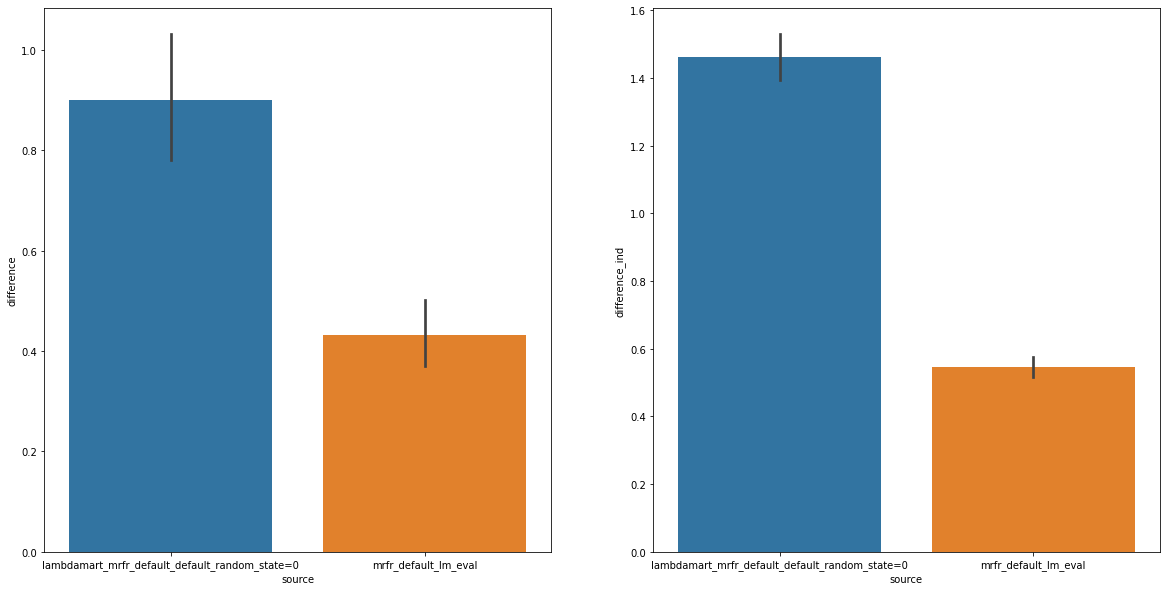

In [128]:
fig, axs = plt.subplots(1,2,figsize=(20,10))
# for ax in axs:
#     ax.set_ylim(0, ymax)

sns.barplot(x='source', y='difference',data=data,ax=axs[0])
sns.barplot(x='source', y='difference_ind',data=data,ax=axs[1])


## Is there a significant improvement in the performance of LambdaMart + AC vs LambdaMart without AC?

### Select data

In [150]:
data = experiments[(experiments.source == 'lambdamart_mrfr_default_default_random_state=0') | (experiments.source == 'ac_controller_default_lm')]
data = data.reset_index(drop=True)
data

,difference,disparity,relevance,difference_ind,disparity_ind,relevance_ind,qid,source
0,0.23910,1.42244,1.24913,0.14971,0.03529,0.01117,95,ac_controller_default_lm
1,0.76381,1.77053,1.38972,0.44681,0.17976,0.08696,612,ac_controller_default_lm
2,2.69675,1.76200,0.32276,0.77073,0.11388,0.06241,657,ac_controller_default_lm
3,0.17600,1.81185,1.29111,0.67444,0.25027,0.17895,771,ac_controller_default_lm
4,0.37616,1.73422,1.56520,0.48771,0.31650,0.20156,822,ac_controller_default_lm
...,...,...,...,...,...,...,...,...
395,0.08143,2.04229,1.69374,0.93860,1.07937,0.16915,119231,lambdamart_mrfr_default_default_random_state=0
396,0.01894,2.14721,1.95367,0.52595,1.08236,0.66969,123512,lambdamart_mrfr_default_default_random_state=0
397,0.14381,1.35630,0.97958,1.26812,1.26668,0.08817,126740,lambdamart_mrfr_default_default_random_state=0
398,0.07780,1.59339,1.24696,1.26301,1.26668,0.28898,128050,lambdamart_mrfr_default_default_random_state=0


In [151]:
from scipy import stats
a = data.query('source == "lambdamart_mrfr_default_default_random_state=0"').reset_index(drop=True)
b = data.query('source == "ac_controller_default_lm"').reset_index(drop=True)

### t-test eel

In [152]:
asub = a['difference']
bsub = b['difference']

In [153]:
stats.ttest_rel(asub, bsub)

Ttest_relResult(statistic=8.44677447541935, pvalue=6.236384153314033e-15)

The difference in scores is significant, p = 0.00000 < 0.05.

In [154]:
effect_size_t_test(asub,bsub)

0.5987759668568923

The effect size is moderate.

In [155]:
differences = asub - bsub
sample_mean = differences.sum()/len(differences)
sample_variance = (differences - sample_mean).apply(lambda x: x*x).sum()/len(differences)

In [156]:
c = ci(len(differences), sample_variance)
cl, ch = (sample_mean - c, sample_mean + c)
round(cl,5), round(ch,5)

(0.37227, 0.59827)

In [157]:
round(sample_mean,5)

0.48527

In [158]:
round(sample_variance,5)

0.65681

### t-test eel_ind

In [159]:
from scipy import stats
asub = a['difference_ind']
bsub = b['difference_ind']

In [160]:
stats.ttest_rel(asub, bsub)

Ttest_relResult(statistic=29.735506623400884, pvalue=3.7837131403965134e-75)

The difference in scores is significant, p = 0.00000 < 0.05.

In [162]:
effect_size_t_test(asub,bsub)

2.107894176672977

The effect size is moderate.

In [163]:
differences = asub - bsub
sample_mean = differences.sum()/len(differences)
sample_variance = (differences - sample_mean).apply(lambda x: x*x).sum()/len(differences)

In [164]:
c = ci(len(differences), sample_variance)
cl, ch = (sample_mean - c, sample_mean + c)
round(cl,5), round(ch,5)

(0.88471, 1.01004)

In [165]:
round(sample_mean,5)

0.94738

In [166]:
round(sample_variance,5)

0.202

### Visualize means of the samples

<AxesSubplot:xlabel='source', ylabel='difference_ind'>

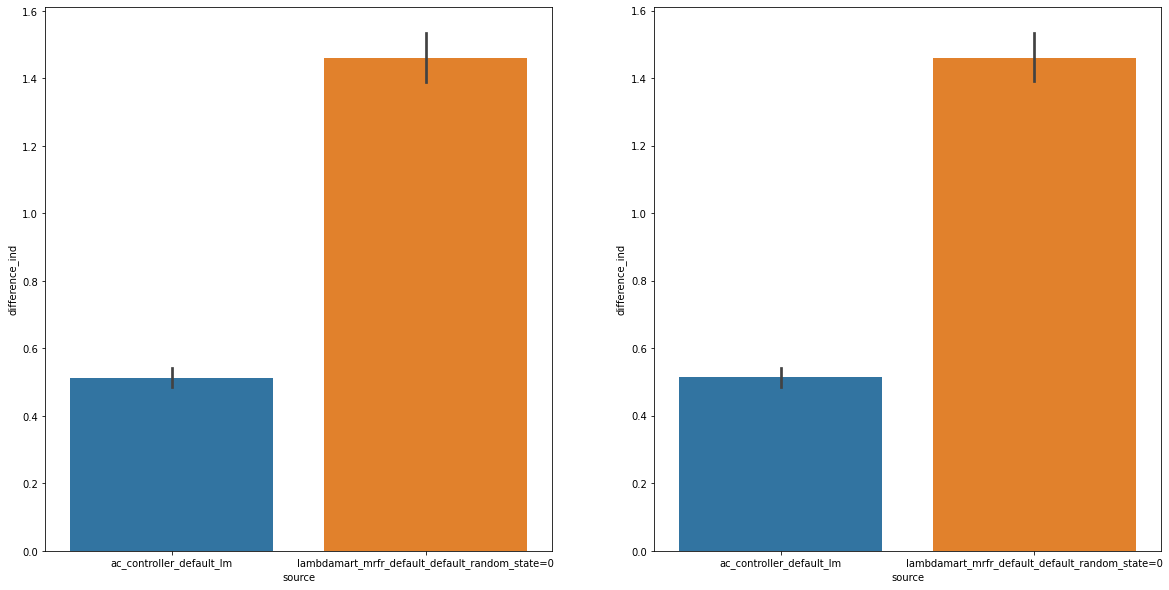

In [168]:
fig, axs = plt.subplots(1,2,figsize=(20,10))
# for ax in axs:
#     ax.set_ylim(0, ymax)

sns.barplot(x='source', y='difference_ind',data=data,ax=axs[0])
sns.barplot(x='source', y='difference_ind',data=data,ax=axs[1])


## Is there a significant improvement in the performance of LambdaMart + RFR vs LambdaMart + AC?

### Select data

In [173]:
data = experiments[(experiments.source == 'mrfr_default_lm_eval') | (experiments.source == 'ac_controller_default_lm')]
data = data.reset_index(drop=True)
data

,difference,disparity,relevance,difference_ind,disparity_ind,relevance_ind,qid,source
0,0.23910,1.42244,1.24913,0.14971,0.03529,0.01117,95,ac_controller_default_lm
1,0.76381,1.77053,1.38972,0.44681,0.17976,0.08696,612,ac_controller_default_lm
2,2.69675,1.76200,0.32276,0.77073,0.11388,0.06241,657,ac_controller_default_lm
3,0.17600,1.81185,1.29111,0.67444,0.25027,0.17895,771,ac_controller_default_lm
4,0.37616,1.73422,1.56520,0.48771,0.31650,0.20156,822,ac_controller_default_lm
...,...,...,...,...,...,...,...,...
395,0.06794,2.07851,1.71860,0.07524,0.15761,0.13995,119231,mrfr_default_lm_eval
396,0.10978,2.17396,1.92162,0.57496,0.35774,0.28288,123512,mrfr_default_lm_eval
397,0.27117,1.42900,0.95225,0.16322,0.19395,0.10425,126740,mrfr_default_lm_eval
398,0.48640,1.10121,0.79658,0.40619,0.19921,0.18365,128050,mrfr_default_lm_eval


In [174]:
from scipy import stats
a = data.query('source == "ac_controller_default_lm"').reset_index(drop=True)
b = data.query('source == "mrfr_default_lm_eval"').reset_index(drop=True)

### t-test eel

In [175]:
asub = a['difference']
bsub = b['difference']

In [176]:
stats.ttest_rel(asub, bsub)

Ttest_relResult(statistic=-1.7950070184937754, pvalue=0.0741700961450265)

The difference in scores is significant, p = 0.00000 < 0.05.

In [177]:
effect_size_t_test(asub,bsub)

0.12724467382682877

The effect size is moderate.

In [178]:
differences = asub - bsub
sample_mean = differences.sum()/len(differences)
sample_variance = (differences - sample_mean).apply(lambda x: x*x).sum()/len(differences)

In [179]:
c = ci(len(differences), sample_variance)
cl, ch = (sample_mean - c, sample_mean + c)
round(cl,5), round(ch,5)

(-0.03594, 0.00164)

In [180]:
round(sample_mean,5)

-0.01715

In [181]:
round(sample_variance,5)

0.01816

### t-test eel_ind

In [182]:
from scipy import stats
asub = a['difference_ind']
bsub = b['difference_ind']

In [183]:
stats.ttest_rel(asub, bsub)

Ttest_relResult(statistic=-6.10780487621202, pvalue=5.214855259867564e-09)

The difference in scores is significant, p = 0.00000 < 0.05.

In [184]:
effect_size_t_test(asub,bsub)

0.4329708080604967

The effect size is moderate.

In [185]:
differences = asub - bsub
sample_mean = differences.sum()/len(differences)
sample_variance = (differences - sample_mean).apply(lambda x: x*x).sum()/len(differences)

In [186]:
c = ci(len(differences), sample_variance)
cl, ch = (sample_mean - c, sample_mean + c)
round(cl,5), round(ch,5)

(-0.04139, -0.02123)

In [187]:
round(sample_mean,5)

-0.03131

In [188]:
round(sample_variance,5)

0.00523

### Visualize means of the samples

<AxesSubplot:xlabel='source', ylabel='difference_ind'>

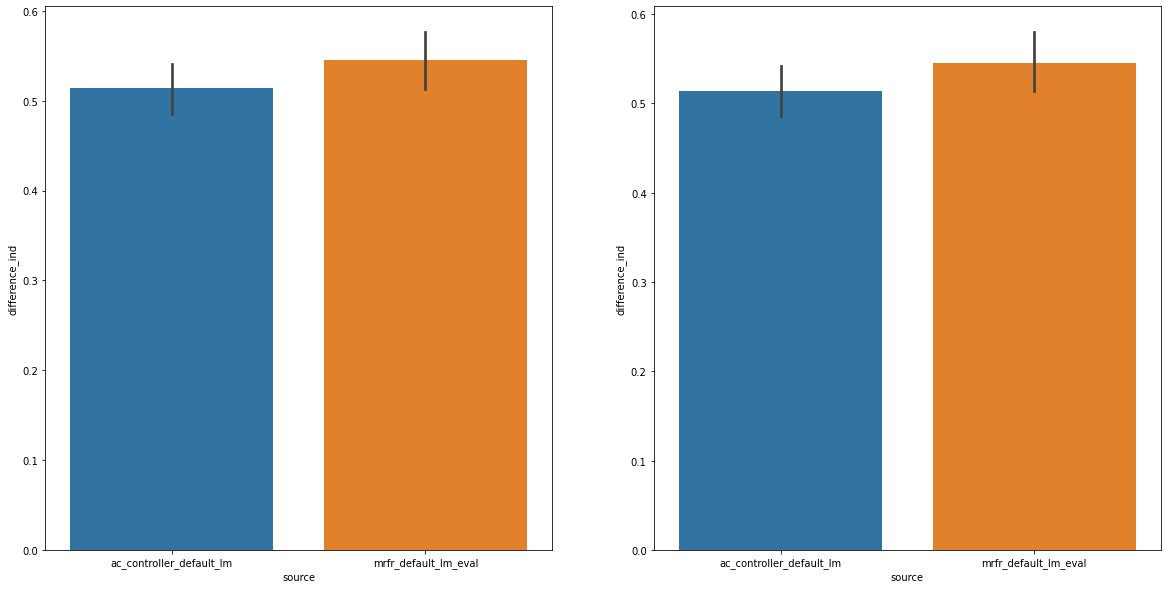

In [189]:
fig, axs = plt.subplots(1,2,figsize=(20,10))
# for ax in axs:
#     ax.set_ylim(0, ymax)

sns.barplot(x='source', y='difference_ind',data=data,ax=axs[0])
sns.barplot(x='source', y='difference_ind',data=data,ax=axs[1])


## Is there a significant improvement in the performance of AC base vs AC doc to doc for META?

### Select data

In [243]:
experiments.source.unique()

array(['ac_controller_default_lm',
       'ac_controller_default_meta_9_eval_old_config',
       'ac_controller_default_meta_9_eval',
       'ac_controller_default_text_9_eval_old_config',
       'ac_controller_default_text_9_eval',
       'lambdamart_mrfr_default_default_random_state=0',
       'mrfr_default_lm_eval', 'relevance_ranker_eval_META_eval',
       'relevance_ranker_eval_TEXT_eval'], dtype=object)

In [244]:
s1 = 'ac_controller_default_meta_9_eval'
s2 = 'ac_controller_default_meta_9_eval_old_config'

In [245]:
data = experiments[(experiments.source == s1) | (experiments.source == s2)]
data = data.reset_index(drop=True)
data

,difference,disparity,relevance,difference_ind,disparity_ind,relevance_ind,qid,source
0,0.35200,2.93676,1.94984,1.11692,0.98604,0.00293,95,ac_controller_default_meta_9_eval_old_config
1,0.99169,1.73147,1.25625,0.37762,0.12248,0.09292,612,ac_controller_default_meta_9_eval_old_config
2,3.70055,2.63171,0.25572,0.93072,0.21487,0.03291,657,ac_controller_default_meta_9_eval_old_config
3,0.29945,1.98737,1.31715,0.67458,0.17690,0.14219,771,ac_controller_default_meta_9_eval_old_config
4,0.71517,1.65668,1.35692,0.57742,0.34905,0.17297,822,ac_controller_default_meta_9_eval_old_config
...,...,...,...,...,...,...,...,...
395,0.15056,2.44868,1.86237,0.10874,0.13291,0.11085,119231,ac_controller_default_meta_9_eval
396,0.15217,2.10207,1.86449,0.58399,0.30692,0.25295,123512,ac_controller_default_meta_9_eval
397,0.12025,1.31108,0.96875,0.11039,0.10157,0.08447,126740,ac_controller_default_meta_9_eval
398,0.69143,1.23131,0.75911,0.46638,0.17588,0.14189,128050,ac_controller_default_meta_9_eval


In [246]:
from scipy import stats
a = data.query(f'source == "{s1}"').reset_index(drop=True)
b = data.query(f'source == "{s2}"').reset_index(drop=True)

### t-test eel

In [247]:
asub = a['difference']
bsub = b['difference']

In [248]:
stats.ttest_rel(asub, bsub)

Ttest_relResult(statistic=-1.8990881102419774, pvalue=0.05899949442741354)

The difference in scores is significant, p = 0.00000 < 0.05.

In [249]:
effect_size_t_test(asub,bsub)

0.13462278680053366

The effect size is moderate.

In [250]:
differences = asub - bsub
sample_mean = differences.sum()/len(differences)
sample_variance = (differences - sample_mean).apply(lambda x: x*x).sum()/len(differences)

In [251]:
c = ci(len(differences), sample_variance)
cl, ch = (sample_mean - c, sample_mean + c)
round(cl,5), round(ch,5)

(-0.05241, 0.00092)

In [252]:
round(sample_mean,5)

-0.02574

In [253]:
round(sample_variance,5)

0.03657

### t-test eel_ind

In [254]:
from scipy import stats
asub = a['difference_ind']
bsub = b['difference_ind']

In [255]:
stats.ttest_rel(asub, bsub)

Ttest_relResult(statistic=-6.8041298125525, pvalue=1.1663991747847864e-10)

The difference in scores is significant, p = 0.00000 < 0.05.

In [256]:
effect_size_t_test(asub,bsub)

0.48233197405553585

The effect size is moderate.

In [257]:
differences = asub - bsub
sample_mean = differences.sum()/len(differences)
sample_variance = (differences - sample_mean).apply(lambda x: x*x).sum()/len(differences)

In [258]:
c = ci(len(differences), sample_variance)
cl, ch = (sample_mean - c, sample_mean + c)
round(cl,5), round(ch,5)

(-0.09905, -0.05463)

In [259]:
round(sample_mean,5)

-0.07684

In [260]:
round(sample_variance,5)

0.02538

### Visualize means of the samples

<AxesSubplot:xlabel='source', ylabel='difference_ind'>

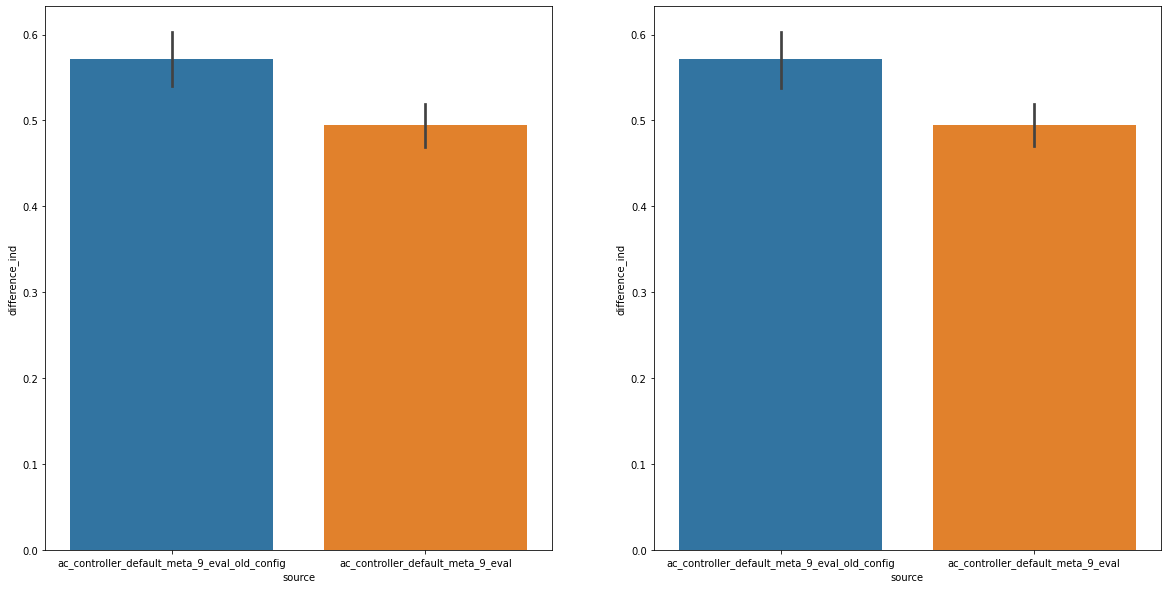

In [261]:
fig, axs = plt.subplots(1,2,figsize=(20,10))
# for ax in axs:
#     ax.set_ylim(0, ymax)

sns.barplot(x='source', y='difference_ind',data=data,ax=axs[0])
sns.barplot(x='source', y='difference_ind',data=data,ax=axs[1])


## Is there a significant improvement in the performance of AC base vs AC doc to doc for TEXT?

### Select data

In [225]:
s1 = 'ac_controller_default_text_9_eval'
s2 = 'ac_controller_default_text_9_eval_old_config'

In [226]:
data = experiments[(experiments.source == s1) | (experiments.source == s2)]
data = data.reset_index(drop=True)
data

,difference,disparity,relevance,difference_ind,disparity_ind,relevance_ind,qid,source
0,0.46567,3.25201,2.05063,0.97818,0.84548,0.00203,95,ac_controller_default_text_9_eval_old_config
1,1.06389,1.76208,1.23545,0.39826,0.12153,0.08212,612,ac_controller_default_text_9_eval_old_config
2,3.92328,2.83716,0.24707,1.00489,0.28676,0.03177,657,ac_controller_default_text_9_eval_old_config
3,0.33006,2.02984,1.32308,0.69114,0.17594,0.13344,771,ac_controller_default_text_9_eval_old_config
4,0.75494,1.65849,1.33794,0.59382,0.35730,0.16890,822,ac_controller_default_text_9_eval_old_config
...,...,...,...,...,...,...,...,...
395,0.13398,2.38984,1.84124,0.10291,0.13054,0.11258,119231,ac_controller_default_text_9_eval
396,0.14900,2.09805,1.86406,0.57226,0.30555,0.25813,123512,ac_controller_default_text_9_eval
397,0.12853,1.35327,0.98570,0.11874,0.10143,0.08023,126740,ac_controller_default_text_9_eval
398,0.67161,1.23895,0.77284,0.46805,0.17496,0.14059,128050,ac_controller_default_text_9_eval


In [227]:
from scipy import stats
a = data.query(f'source == "{s1}"').reset_index(drop=True)
b = data.query(f'source == "{s2}"').reset_index(drop=True)

### t-test eel

In [228]:
asub = a['difference']
bsub = b['difference']

In [229]:
stats.ttest_rel(asub, bsub)

Ttest_relResult(statistic=-2.395531305600646, pvalue=0.01752296958297589)

The difference in scores is significant, p = 0.00000 < 0.05.

In [230]:
effect_size_t_test(asub,bsub)

0.16981471185493785

The effect size is moderate.

In [231]:
differences = asub - bsub
sample_mean = differences.sum()/len(differences)
sample_variance = (differences - sample_mean).apply(lambda x: x*x).sum()/len(differences)

In [232]:
c = ci(len(differences), sample_variance)
cl, ch = (sample_mean - c, sample_mean + c)
round(cl,5), round(ch,5)

(-0.06423, -0.00631)

In [233]:
round(sample_mean,5)

-0.03527

In [234]:
round(sample_variance,5)

0.04314

### t-test eel_ind

In [235]:
from scipy import stats
asub = a['difference_ind']
bsub = b['difference_ind']

In [236]:
stats.ttest_rel(asub, bsub)

Ttest_relResult(statistic=-7.029660922505702, pvalue=3.2345039464592856e-11)

The difference in scores is significant, p = 0.00000 < 0.05.

In [237]:
effect_size_t_test(asub,bsub)

0.4983194505545852

The effect size is moderate.

In [238]:
differences = asub - bsub
sample_mean = differences.sum()/len(differences)
sample_variance = (differences - sample_mean).apply(lambda x: x*x).sum()/len(differences)

In [239]:
c = ci(len(differences), sample_variance)
cl, ch = (sample_mean - c, sample_mean + c)
round(cl,5), round(ch,5)

(-0.11489, -0.06466)

In [240]:
round(sample_mean,5)

-0.08978

In [241]:
round(sample_variance,5)

0.03246

### Visualize means of the samples

<AxesSubplot:xlabel='source', ylabel='difference_ind'>

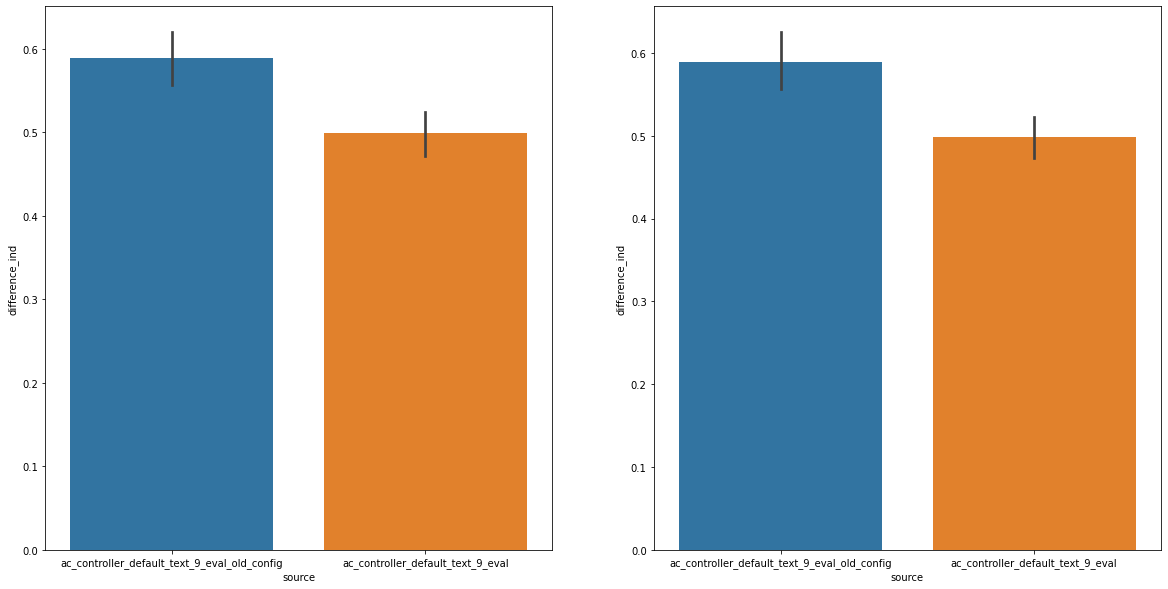

In [242]:
fig, axs = plt.subplots(1,2,figsize=(20,10))
# for ax in axs:
#     ax.set_ylim(0, ymax)

sns.barplot(x='source', y='difference_ind',data=data,ax=axs[0])
sns.barplot(x='source', y='difference_ind',data=data,ax=axs[1])
